In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

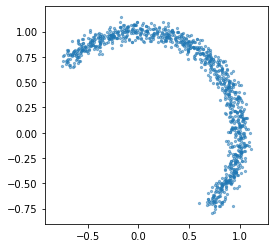

In [25]:
# Lightweight datasets
import pickle
from sklearn import datasets


class DatasetMoon:
    def _make_moon(self, n_samples=100, shuffle=True, noise=None, random_state=None):
        from sklearn.utils import shuffle as util_shuffle
        from sklearn.utils import check_random_state
        import numpy as np
        """Make two interleaving half circles
        A simple toy dataset to visualize clustering and classification
        algorithms. Read more in the :ref:`User Guide <sample_generators>`.
        Parameters
        ----------
        n_samples : int, optional (default=100)
            The total number of points generated.
        shuffle : bool, optional (default=True)
            Whether to shuffle the samples.
        noise : double or None (default=None)
            Standard deviation of Gaussian noise added to the data.
        random_state : int, RandomState instance or None (default)
            Determines random number generation for dataset shuffling and noise.
            Pass an int for reproducible output across multiple function calls.
            See :term:`Glossary <random_state>`.
        Returns
        -------
        X : array of shape [n_samples, 2]
            The generated samples.
        y : array of shape [n_samples]
            The integer labels (0 or 1) for class membership of each sample.
        """
    
        generator = check_random_state(random_state)
    
        outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))
        outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))
    
        X = np.vstack([outer_circ_x, outer_circ_y]).T
        y = np.zeros(n_samples, dtype=np.intp)
    
        if shuffle:
            X, y = util_shuffle(X, y, random_state=generator)
    
        if noise is not None:
            X += generator.normal(scale=noise, size=X.shape)
            
        # rotate
        c, s = np.cos(3.1415926/4), np.sin(3.1415926/4)
        X = X @ np.array([[c, -s],
                          [s,  c]])
    
        return X, y

    def sample(self, n):
        moon = self._make_moon(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moon)

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoon()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(1000)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [26]:
class PPCA(torch.distributions.Distribution, torch.nn.Module):

    def __init__(self, data_dim, latent_dim, linear_transform=None, data_mean=None, noise_variance=1e-1):
        super(PPCA, self).__init__()
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        
        if data_mean is None:
            data_mean = torch.zeros((data_dim,))
        device = data_mean.device
        self.device = device
        self.data_mean = data_mean

        if linear_transform is None:
            self.linear_transform = torch.eye(data_dim, latent_dim, device=device)
        else:
            self.linear_transform = linear_transform

        noise_variance = torch.tensor([noise_variance], device=device)
        #self.raw_noise_variance = torch.nn.Parameter(self._unconstrain(noise_variance))
        self.raw_noise_variance = self._unconstrain(noise_variance)
        
        self.latent_distribution = torch.distributions.Normal(0, torch.ones(self.latent_dim, device=device))
        
    def __hash__(self):
        return super(torch.nn.Module, self).__hash__()
        
    @property
    def mean(self):
        return self.data_mean
    
    @property
    def covariance_matrix(self):
        return self.linear_transform @ self.linear_transform.T + self.noise_variance * torch.eye(self.data_dim, device=self.device)

    @property
    def noise_variance(self):
        return self._constrain(self.raw_noise_variance) * torch.ones((self.data_dim))
    
    @property
    def noise_distribution(self):
        return torch.distributions.Normal(0, self.noise_variance.sqrt())

    def _constrain(self, x):
        # Softplus
        return torch.log(torch.exp(x) + 1)
    
    def _unconstrain(self, x):
        # Inverse softplus
        return x + torch.log(-torch.expm1(-x))
        
    def sample(self, sample_shape):
        latent = self.latent_distribution.sample(sample_shape)
        data_noise = self.noise_distribution.sample(sample_shape)

        samples = latent @ self.linear_transform.T + self.data_mean + data_noise
        return samples

    def log_prob(self, x):
        # TODO: Cache cholesky of the distribution
        # TODO: pass precision matrix instead
        distrib = distributions.MultivariateNormal(self.mean, self.covariance_matrix)
        return distrib.log_prob(x)

In [27]:
# construct a model
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
# prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution
prior = PPCA(2, 1)

# RealNVP
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
#flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
#flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# Neural splines, coupling
# nfs_flow = NSF_CL if True else NSF_AR
# flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
# convs = [Invertible1x1Conv(dim=2) for _ in flows]
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)

In [28]:
with torch.no_grad():
    zs, _, _ = model(d.sample(1000))

def covariance_matrix(x):
    n = x.size(0)
    x_centered = x - x.mean(0)
    return x_centered.T.matmul(x_centered).div(n)

z = zs[-1]

#U, S, V = torch.svd(covariance_matrix(z))
U, S, V = torch.svd(prior.covariance_matrix)

#prior.data_mean = z.mean(0)
#prior.linear_transform = U[:, 0:1]
#prior.linear_transform = U

Text(0.5, 1.0, 'sampled x')

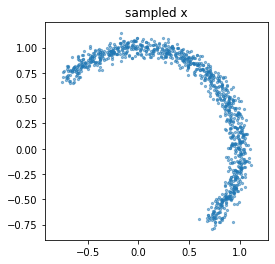

In [29]:
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');
plt.title("sampled x")

Text(0.5, 1.0, 'f(sampled x)')

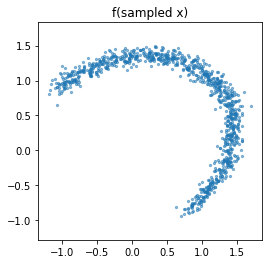

In [30]:
z = zs[-1].detach().numpy()
plt.figure(figsize=(4,4))
plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5)
plt.axis('equal');
plt.title("f(sampled x)")

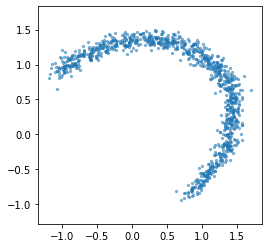

In [32]:
z = zs[-1]
u = z.matmul(U).detach().numpy()
plt.figure(figsize=(4,4))
plt.scatter(u[:,0], u[:,1], s=5, alpha=0.5)
plt.axis('equal');

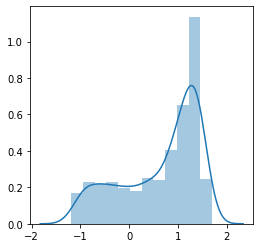

In [33]:
import seaborn as sns
z = zs[-1]
u = z.matmul(U[:, :prior.latent_dim]).detach().numpy()
plt.figure(figsize=(4,4))
#plt.scatter(u[:,0], u[:,1], s=5, alpha=0.5)
#plt.plot(u, np.zeros_like(u), 'o')
sns.distplot(u[:, 0])
#plt.axis('equal');

In [34]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, amsgrad=True) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  22914


In [35]:
model.train()
for k in range(1000):
    x = d.sample(128)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


662.3060302734375
190.52725219726562
143.9326171875
97.44511413574219
41.5538215637207
-18.526588439941406
-37.21110916137695
-41.800846099853516
-32.59259796142578
-55.63693618774414


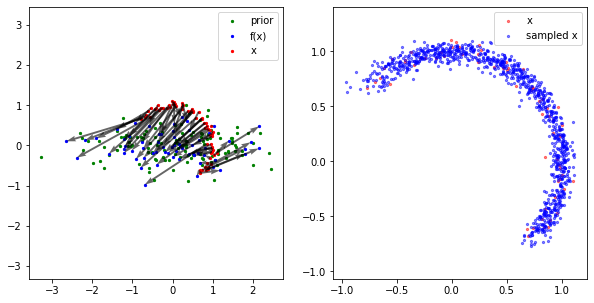

In [36]:
model.eval()

x = d.sample(64)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='b', s=5)
plt.scatter(x[:,0], x[:,1], c='r', s=5)
plt.quiver(x[:,0], x[:,1], z[:,0] - x[:,0], z[:,1] - x[:,1], units='xy', scale=1, alpha=0.6)
plt.legend(['prior', 'f(x)', 'x'])
plt.axis('equal')

xs_sampled = model.sample(128*8)
x_sampled = xs_sampled[-1]
x_sampled = x_sampled.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x_sampled[:,0], x_sampled[:,1], c='b', s=5, alpha=0.5)
plt.legend(['x', 'sampled x'])
plt.axis('equal');

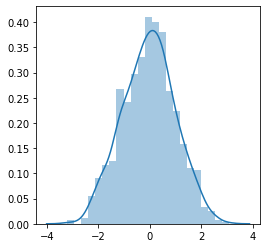

In [37]:
with torch.no_grad():
    zs, _, _ = model(d.sample(1000))

z = zs[-1]
u = z.matmul(U[:, :prior.latent_dim]).detach().numpy()
plt.figure(figsize=(4,4))
sns.distplot(u[:, 0])

Text(0.5, 1.0, 'Principal axes of z')

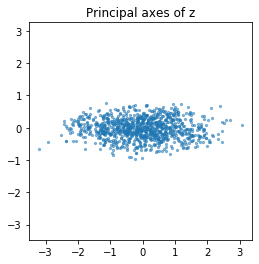

In [38]:
z = zs[-1]
u = z.matmul(U).detach().numpy()
plt.figure(figsize=(4,4))
plt.scatter(u[:,0], u[:,1], s=5, alpha=0.5)
plt.axis('equal');
plt.title("Principal axes of z")

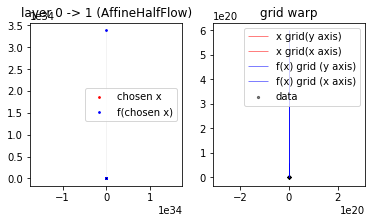

In [15]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))


zs, _, log_det = model(xy)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]

# Show first and last
zs = [zs[0], zs[-1]]

nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.1)
    axs[0].axis("equal")
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    axs[0].legend(["chosen x", "f(chosen x)"])
    
    q = z0.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='r')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='r')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='b')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='b')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis("equal")
    
    axs[1].set_title("grid warp")
    
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='k', s=5, alpha=0.5)
    
    axs[1].legend(["x grid(y axis)", "x grid(x axis)", "f(x) grid (y axis)", "f(x) grid (x axis)", "data"])


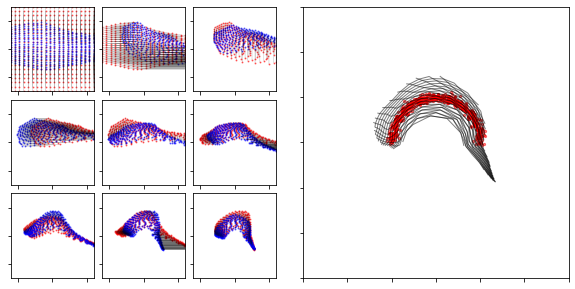

In [29]:

# train and render
# code duplication because it's very late at night now and i'm tired

import matplotlib.gridspec as gridspec

ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

xval = d.sample(128*5)

model.train()
for k in range(500):
    
    # sample
    x = d.sample(128)
    
    # train a bit
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if k % 10 == 0:
        # vis
        zs, log_det = model.backward(xy)
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        i = nz - 1 - 1

        z0 = zs[i].detach().numpy()
        z1 = zs[i+1].detach().numpy()

        # plot how the samples travel at this stage
        ss = 0.1
        fig = plt.figure(figsize=(10, 5))
        outer = gridspec.GridSpec(1, 2, wspace=ss, hspace=ss)
        inner1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=ss, hspace=ss)
        inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=ss, hspace=ss)
        
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        for i in range(min(nz-1, 9)):
            ax = plt.Subplot(fig, inner1[i])
            z0 = zs[i].detach().numpy()
            z1 = zs[i+1].detach().numpy()
            ax.scatter(z0[:,0], z0[:, 1], c='r', s=1, alpha=0.5)
            ax.scatter(z1[:,0], z1[:, 1], c='b', s=1, alpha=0.5)
            ax.quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
            ax.axis([-3, 3, -3, 3])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            #ax.set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
            fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner2[0])
        q = z1.reshape((ng, ng, 2))
        # y coords
        p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # x coords
        p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # draw the lines
        ax.add_collection(lcy)
        ax.add_collection(lcx)
        ax.axis([-3, 3, -3, 3])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        #ax.set_title("grid warp at the end of %d" % (i+1,))
        fig.add_subplot(ax)
        
        # draw the data too
        plt.scatter(xval[:,0], xval[:,1], c='r', s=5, alpha=0.5)
        
        break
        #fname = 'out/step_%04d.png' % (k,)
        #plt.savefig(fname, dpi=200)
        #print("saved", fname, 'loss', loss.item())
        #plt.close(fig)
        